![Transformer](images/Transfomer.png)

## Imports

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

## Word Embeddings

* Neural networks inherently do not comprehend textual data in its raw form—words must be transformed into numerical representations (tokens) for the model to process them.

* Therefore, it's essential to convert words into tokens using a predefined vocabulary or dictionary.

In this example, we use a dummy vocabulary for simplicity. However, in the "Attention Is All You Need" paper, the actual vocabulary size exceeds 50,000 tokens.

In [2]:
sentences = ['ich mochte ein buch P', 'S i want a book', 'i want a book E']  
# German, English(with SOS), English(with EOS)

src_vocab = {'P': 0, 'ich': 1, 'mochte': 2, 'ein': 3, 'buch': 4}
src_vocab_size = len(src_vocab)

tgt_vocab = {'P': 0, 'i': 1, 'want': 2, 'a': 3, 'book': 4, 'S': 5, 'E': 6}
number_dict = {i: w for i, w in enumerate(tgt_vocab)}
tgt_vocab_size = len(tgt_vocab)

src_len = 5 # length of source
tgt_len = 5 # length of target

In [3]:
def make_batch(sentences):
    input_batch = [[src_vocab[n] for n in sentences[0].split()]]
    output_batch = [[tgt_vocab[n] for n in sentences[1].split()]]
    target_batch = [[tgt_vocab[n] for n in sentences[2].split()]]
    return torch.LongTensor(input_batch), torch.LongTensor(output_batch), torch.LongTensor(target_batch)

In [4]:
### Example:

input_batch, output_batch, target_batch = make_batch(sentences=sentences)
print("Input Batch (German):", input_batch)
print("Output Batch (English with SOS):", output_batch)
print("Target Batch (English with EOS):", target_batch)

Input Batch (German): tensor([[1, 2, 3, 4, 0]])
Output Batch (English with SOS): tensor([[5, 1, 2, 3, 4]])
Target Batch (English with EOS): tensor([[1, 2, 3, 4, 6]])


* The task illustrated above is German-to-English translation.
* The German sentence serves as input to the Encoder, which we will explore in detail later.
* The English sentence acts as the Decoder input, prefixed with a Start-of-Sentence (SOS) token to initiate the decoding process.
* The target sequence is essentially the next token version of the decoder input—i.e., target[i] = output[i+1].
* This alignment enables the Transformer to learn to predict the next token at each step, based on what it has already generated and the encoder’s context.

## Positional Encoding

* To inject information about the position of each token in the sequence, Positional Encoding is added to the input embeddings.

* These encodings are computed using fixed sinusoidal functions (sine and cosine) of different frequencies, allowing the model to learn relative and absolute positions.

* The positional encodings are added (element wise) to the input embeddings before feeding them into the encoder.

* This positional information helps the model distinguish between tokens that appear in different positions, enabling it to model sequence order without recurrence or convolution.

In [5]:
def get_sinusoid_encoding_table(n_position, d_model):
    def cal_angle(position, hid_idx):
        return position / np.power(10000, 2 * (hid_idx // 2) / d_model)
    def get_posi_angle_vec(position):
        return [cal_angle(position, hid_j) for hid_j in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(n_position)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # dim 2i
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # dim 2i+1
    return torch.FloatTensor(sinusoid_table)

In [6]:
no_of_words = 10
embedding_size_per_word = 512
temp = get_sinusoid_encoding_table(no_of_words, embedding_size_per_word)
print(temp.shape)
# (No of words, Embedding dim per word)

torch.Size([10, 512])


This positional encoding and input embedding will be element wise added to get final embedding that will be passed to attention layers like this:

!![Final Embedding](images/Embedding_layer.png)


Now this will be passed to multi headed attention layer which we are going to see ahead.

## Multi-Head Attention & Helper Functions
* Multi-head attention (n_heads) enables the model to attend to information from different representation subspaces simultaneously, allowing each head to capture unique semantic relationships in parallel.

* Multiple layers (n_layers) refer to the repeated stacking of attention and feed-forward blocks, allowing the model to learn deeper and more abstract representations at each level.

In [7]:
d_model = 512  # Embedding Size
d_ff = 2048    # FeedForward dimension
d_k = d_v = 64 # dimension of K(=Q), V
n_layers = 6   # number of Encoder of Decoder Layer (Nx in the diagram)
n_heads = 8    # number of heads in Multi-Head Attention  (No of heads to capture the different type of info whilst. parallely working)

In [8]:
def get_attn_pad_mask(seq_q, seq_k):
    """Creates a padding mask to ignore <PAD> tokens during attention calculation. 
       Padding tokens don't carry meaning and must be excluded from contributing to the attention."""
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()
    # eq(zero) is PAD token
    pad_attn_mask = seq_k.data.eq(0).unsqueeze(1)  # batch_size x 1 x len_k(=len_q), one is masking
    return pad_attn_mask.expand(batch_size, len_q, len_k)  # batch_size x len_q x len_k

* seq_k.data.eq(0) returns a boolean mask where padding tokens are True (i.e., value 0).
* unsqueeze(1) reshapes to add an extra dim for broadcasting → shape becomes [batch_size, 1, len_k]
* expand(batch_size, len_q, len_k) replicates the mask across all query positions.
* Used in both encoder and decoder to prevent attending to padded positions in the input.

In [9]:
def get_attn_subsequent_mask(seq):
    """Creates a look-ahead mask to prevent the decoder from "seeing the future" during training 
       (i.e., no peeking at tokens it hasn't generated yet) -- for decoder.
    """
    attn_shape = [seq.size(0), seq.size(1), seq.size(1)]
    subsequent_mask = np.triu(np.ones(attn_shape), k=1)
    subsequent_mask = torch.from_numpy(subsequent_mask).byte()
    return subsequent_mask

* Constructs a triangular matrix (np.triu) with 1s above the diagonal (upper triangle).
* Shape: [batch_size, tgt_len, tgt_len]
* Final mask blocks all positions after the current one in a sequence.
* Used only in decoder self-attention.

In [10]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self):
        super(ScaledDotProductAttention, self).__init__()

    def forward(self, Q, K, V, attn_mask):
        scores = torch.matmul(Q, K.transpose(-1, -2)) / np.sqrt(d_k) # scores : [batch_size x n_heads x len_q(=len_k) x len_k(=len_q)]
        scores.masked_fill_(attn_mask, -1e9) # Fills elements of self tensor with value where mask is one.
        attn = nn.Softmax(dim=-1)(scores)
        context = torch.matmul(attn, V)
        return context, attn

* Score Computation: This measures how well each token aligns with the others (The QK softmax equation).
* Masking: Applies padding or look-ahead masks — essentially zeroing out attention where needed.
* Softmax: Turns scores into probabilities → attention weights.
* Context Vector: Weighted sum of values, depending on attention weights.

The visualization and in-depth explaination of the multi-headed attention:

![Query Key Value](images/qkv.png)


### The query, key and value pair are generated in each head.  The process is as follows:

* Suppose the max sentence length is 10 and each word is a 512 dim embedding. Thus, Input sentence: (10, 512)
* Then a W_q, W_k and W_v is initialized and it is of dimension: (512, 64) .... (if 8 heads because this 64x8=512 which is same as initial dimension).
* Thus, each Q, K, V will have (10, 64) dimension and all heads will concatenate at last making dimension of (10, 512) and original dimension is preserved.

* This Q and K will be multiplied element wise as Q.K_Transpose giving dimension of (10, 10). This will be passed to softmax function for probabilities.
* This (10, 10) will be the representation of how the words are dependent on each other. This will be passed to softmax function as follows:

!![alt](images/eqn.png)

* The idea is that dividing by sqrt(dk) helps to normalize the dot product values, preventing them from becoming too large and maintaining a manageable range of values for the input to the softmax function.
* This softmax output will be multiplied with Value matrix to get the **weighted value matrix**. 
* This weighted value matrix will be context aware of all the words in the sentence.

This all will have a batch dimension added to them for parallelism and efficiency.

In [11]:
class MultiHeadAttention(nn.Module):
    def __init__(self):
        super(MultiHeadAttention, self).__init__()
        self.W_Q = nn.Linear(d_model, d_k * n_heads)  # (512, 64x8)  
        self.W_K = nn.Linear(d_model, d_k * n_heads)
        self.W_V = nn.Linear(d_model, d_v * n_heads)
        self.linear = nn.Linear(n_heads * d_v, d_model)
        self.layer_norm = nn.LayerNorm(d_model)

    def forward(self, Q, K, V, attn_mask):
        # q: [batch_size x len_q x d_model], 
        # k: [batch_size x len_k x d_model], 
        # v: [batch_size x len_k x d_model]

        residual, batch_size = Q, Q.size(0)

        # (B, S, D) -proj-> (B, S, D) -split-> (B, S, H, W) -trans-> (B, H, S, W)
        q_s = self.W_Q(Q).view(batch_size, -1, n_heads, d_k).transpose(1,2)  # q_s: [batch_size x n_heads x len_q x d_k]
        k_s = self.W_K(K).view(batch_size, -1, n_heads, d_k).transpose(1,2)  # k_s: [batch_size x n_heads x len_k x d_k]
        v_s = self.W_V(V).view(batch_size, -1, n_heads, d_v).transpose(1,2)  # v_s: [batch_size x n_heads x len_k x d_v]

        attn_mask = attn_mask.unsqueeze(1).repeat(1, n_heads, 1, 1)          # attn_mask: [batch_size x n_heads x len_q x len_k]

        # context: [batch_size x n_heads x len_q x d_v], attn: [batch_size x n_heads x len_q(=len_k) x len_k(=len_q)]
        context, attn = ScaledDotProductAttention()(q_s, k_s, v_s, attn_mask)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, n_heads * d_v) # context: [batch_size x len_q x n_heads * d_v]
        output = self.linear(context)
        return self.layer_norm(output + residual), attn # output: [batch_size x len_q x d_model]

![Feed Forward NN](images/FFnn.png)

In [12]:
class PoswiseFeedForwardNet(nn.Module):
    """Feed Forward nn for enhanced capturing of information.
       Brings the output from attention back to original input shape.
       Also introduces non-linearity to capture feature more efficiently"""
    def __init__(self):
        super(PoswiseFeedForwardNet, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=d_model, out_channels=d_ff, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=d_ff, out_channels=d_model, kernel_size=1)
        self.layer_norm = nn.LayerNorm(d_model)

    def forward(self, inputs):
        residual = inputs # inputs : [batch_size, len_q, d_model]
        output = nn.ReLU()(self.conv1(inputs.transpose(1, 2)))
        output = self.conv2(output).transpose(1, 2)
        return self.layer_norm(output + residual) # Original input features is obtained from this.

![Encoder Block](images/Encoder.png)

* Positional Encoded word embeddings -> MultiHead Attention -> Concatenation -> Feed forward (regain the original shape of input and introduce non-linearlity to capture semantics more efficiently).

* Multi-headed attention captures the semantics and outputs a refined version of Value matrix which contains all the meaning (semantics) from the previous and ahead words.

In [13]:
class EncoderLayer(nn.Module):
    """Multi Head Attention followed by FeedForwardNN along with Add and Normalization. Please refer above picture for viz."""
    def __init__(self):
        super(EncoderLayer, self).__init__()
        self.enc_self_attn = MultiHeadAttention()
        self.pos_ffn = PoswiseFeedForwardNet()

    def forward(self, enc_inputs, enc_self_attn_mask):
        enc_outputs, attn = self.enc_self_attn(enc_inputs, enc_inputs, enc_inputs, enc_self_attn_mask) # enc_inputs to same Q,K,V
        enc_outputs = self.pos_ffn(enc_outputs) # enc_outputs: [batch_size x len_q x d_model]
        return enc_outputs, attn

![Decoder Block](images/Decoder.png)

* The target embeddings (i.e., the output sentence so far) are first passed through the Masked Multi-Head Attention block.
* This attention layer uses a look-ahead mask (also called a subsequent mask) to ensure that each position can only attend to previous and current positions — not future ones. This mask replaces ahead words with -infinity. 
* Why -infinity -> Because the softmax function's equation make it 0, thus minimizing its impact on previous words.

![Masked Muti-Head Attention](images/Masked_MHA.png)
* This restriction is crucial during training, because:
    * Without it, the model would "peek" at the correct next word while predicting — which would be data leakage or cheating.
    * This masking enforces autoregressive behavior, enabling the decoder to generate tokens one at a time during inference, just like language models.

* The output of this masked attention block is passed to the second multi-head attention block in the decoder.
* Here, the Query (Q) comes from output of the decoder side and the Key (K) and Value (V) come from the encoder outputs.
* The weighted value matrix is then obtained, concatenated and passed through feed forward layer.
This completes the decoder block. 

In [14]:
class DecoderLayer(nn.Module):
    def __init__(self):
        super(DecoderLayer, self).__init__()
        self.dec_self_attn = MultiHeadAttention()
        self.dec_enc_attn = MultiHeadAttention()
        self.pos_ffn = PoswiseFeedForwardNet()

    def forward(self, dec_inputs, enc_outputs, dec_self_attn_mask, dec_enc_attn_mask):
        dec_outputs, dec_self_attn = self.dec_self_attn(dec_inputs, dec_inputs, dec_inputs, dec_self_attn_mask)
        dec_outputs, dec_enc_attn = self.dec_enc_attn(dec_outputs, enc_outputs, enc_outputs, dec_enc_attn_mask)
        dec_outputs = self.pos_ffn(dec_outputs)
        return dec_outputs, dec_self_attn, dec_enc_attn

* The Encoder is N times the encoder layer.
* The process is repeated n-times to make sure all the semantics and dependencies are captured.

In [15]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.src_emb = nn.Embedding(src_vocab_size, d_model)    # Embedding layer
        self.pos_emb = nn.Embedding.from_pretrained(get_sinusoid_encoding_table(src_len+1, d_model),freeze=True)  #Positional Encoding layer
        self.layers = nn.ModuleList([EncoderLayer() for _ in range(n_layers)])   # Nx EncoderLayer

    def forward(self, enc_inputs): # enc_inputs : [batch_size x source_len]
        enc_outputs = self.src_emb(enc_inputs) + self.pos_emb(torch.LongTensor([[1,2,3,4,0]]))   # Embedding + Positional Encoding
        enc_self_attn_mask = get_attn_pad_mask(enc_inputs, enc_inputs)  # Padding Mask
        enc_self_attns = []
        for layer in self.layers:
            enc_outputs, enc_self_attn = layer(enc_outputs, enc_self_attn_mask)
            enc_self_attns.append(enc_self_attn)
        return enc_outputs, enc_self_attns

In [16]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.tgt_emb = nn.Embedding(tgt_vocab_size, d_model)    # Word Embedding
        self.pos_emb = nn.Embedding.from_pretrained(get_sinusoid_encoding_table(tgt_len+1, d_model),freeze=True) # Positional Encoding
        self.layers = nn.ModuleList([DecoderLayer() for _ in range(n_layers)])    # Nx DecoderLayer

    def forward(self, dec_inputs, enc_inputs, enc_outputs): # dec_inputs : [batch_size x target_len]
        dec_outputs = self.tgt_emb(dec_inputs) + self.pos_emb(torch.LongTensor([[5,1,2,3,4]]))    # Embedding + Positional Encoding
        dec_self_attn_pad_mask = get_attn_pad_mask(dec_inputs, dec_inputs)     # Padding Attention mask
        dec_self_attn_subsequent_mask = get_attn_subsequent_mask(dec_inputs)   # Multi-Head Attention mask
        dec_self_attn_mask = torch.gt((dec_self_attn_pad_mask + dec_self_attn_subsequent_mask), 0)  # Combined previous 2 masks

        dec_enc_attn_mask = get_attn_pad_mask(dec_inputs, enc_inputs) # Prevents decoder from attending to PADs in the encoder outputs

        dec_self_attns, dec_enc_attns = [], []
        for layer in self.layers:
            dec_outputs, dec_self_attn, dec_enc_attn = layer(dec_outputs, enc_outputs, dec_self_attn_mask, dec_enc_attn_mask)
            dec_self_attns.append(dec_self_attn)
            dec_enc_attns.append(dec_enc_attn)
        return dec_outputs, dec_self_attns, dec_enc_attns

In [17]:
class Transformer(nn.Module):      # Combined Encoders and Decoders Layers
    def __init__(self):
        super(Transformer, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.projection = nn.Linear(d_model, tgt_vocab_size, bias=False)
    def forward(self, enc_inputs, dec_inputs):
        enc_outputs, enc_self_attns = self.encoder(enc_inputs)
        dec_outputs, dec_self_attns, dec_enc_attns = self.decoder(dec_inputs, enc_inputs, enc_outputs)
        dec_logits = self.projection(dec_outputs) # dec_logits : [batch_size x src_vocab_size x tgt_vocab_size]
        return dec_logits.view(-1, dec_logits.size(-1)), enc_self_attns, dec_self_attns, dec_enc_attns

In [18]:
def showgraph(attn):
    """Plot graphs for attention layers"""
    attn = attn[-1].squeeze(0)[0]
    attn = attn.squeeze(0).data.numpy()
    fig = plt.figure(figsize=(n_heads, n_heads)) # [n_heads, n_heads]
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attn, cmap='viridis')
    ax.set_xticklabels(['']+sentences[0].split(), fontdict={'fontsize': 14}, rotation=90)
    ax.set_yticklabels(['']+sentences[2].split(), fontdict={'fontsize': 14})
    plt.show()

------

## Sample training

In [19]:
sentences = ['ich mochte ein buch P', 'S i want a book', 'i want a book E']
src_vocab = {'P': 0, 'ich': 1, 'mochte': 2, 'ein': 3, 'buch': 4}
src_vocab_size = len(src_vocab)

tgt_vocab = {'P': 0, 'i': 1, 'want': 2, 'a': 3, 'book': 4, 'S': 5, 'E': 6}
number_dict = {i: w for i, w in enumerate(tgt_vocab)}
tgt_vocab_size = len(tgt_vocab)

src_len = 5 # length of source
tgt_len = 5 # length of target

d_model = 512  # Embedding Size
d_ff = 2048  # FeedForward dimension
d_k = d_v = 64  # dimension of K(=Q), V
n_layers = 6  # number of Encoder of Decoder Layer
n_heads = 8  # number of heads in Multi-Head Attention

In [20]:
model = Transformer()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

enc_inputs, dec_inputs, target_batch = make_batch(sentences)
for epoch in range(20):
    optimizer.zero_grad()
    outputs, enc_self_attns, dec_self_attns, dec_enc_attns = model(enc_inputs, dec_inputs)
    loss = criterion(outputs, target_batch.contiguous().view(-1))
    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))
    loss.backward()
    optimizer.step()

Epoch: 0001 cost = 2.296342
Epoch: 0002 cost = 1.159179
Epoch: 0003 cost = 4.673470
Epoch: 0004 cost = 3.840153
Epoch: 0005 cost = 4.028556
Epoch: 0006 cost = 2.651024
Epoch: 0007 cost = 1.989865
Epoch: 0008 cost = 2.584510
Epoch: 0009 cost = 1.829306
Epoch: 0010 cost = 1.952755
Epoch: 0011 cost = 1.565020
Epoch: 0012 cost = 1.617409
Epoch: 0013 cost = 1.575526
Epoch: 0014 cost = 1.509725
Epoch: 0015 cost = 1.470095
Epoch: 0016 cost = 1.423712
Epoch: 0017 cost = 1.340472
Epoch: 0018 cost = 1.200232
Epoch: 0019 cost = 1.008104
Epoch: 0020 cost = 0.902897


## Testing 

In [21]:
# S: Symbol that shows starting of decoding input
# E: Symbol that shows starting of decoding output
# P: Symbol that will fill in blank sequence if current batch data size is short than time steps

In [22]:
import warnings
warnings.filterwarnings('ignore')
predict, _, _, _ = model(enc_inputs, dec_inputs)
predict = predict.data.max(1, keepdim=True)[1]
print(sentences[0], '->', [number_dict[n.item()] for n in predict.squeeze()])

ich mochte ein buch P -> ['want', 'want', 'a', 'want', 'E']


first head of last state enc_self_attns


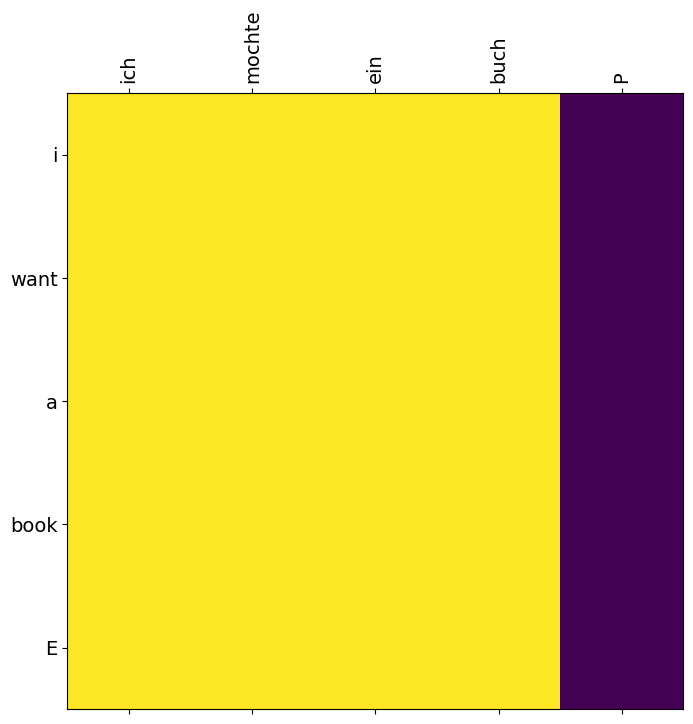

first head of last state dec_self_attns


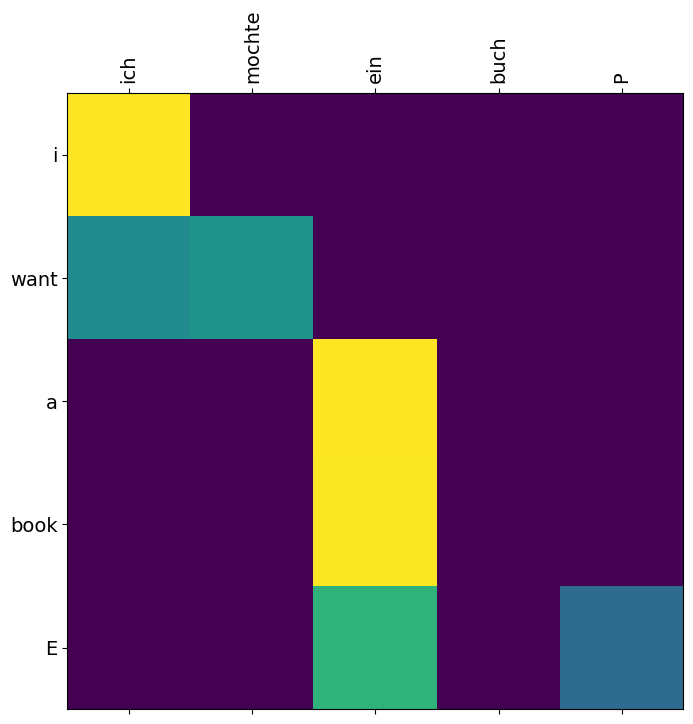

first head of last state dec_enc_attns


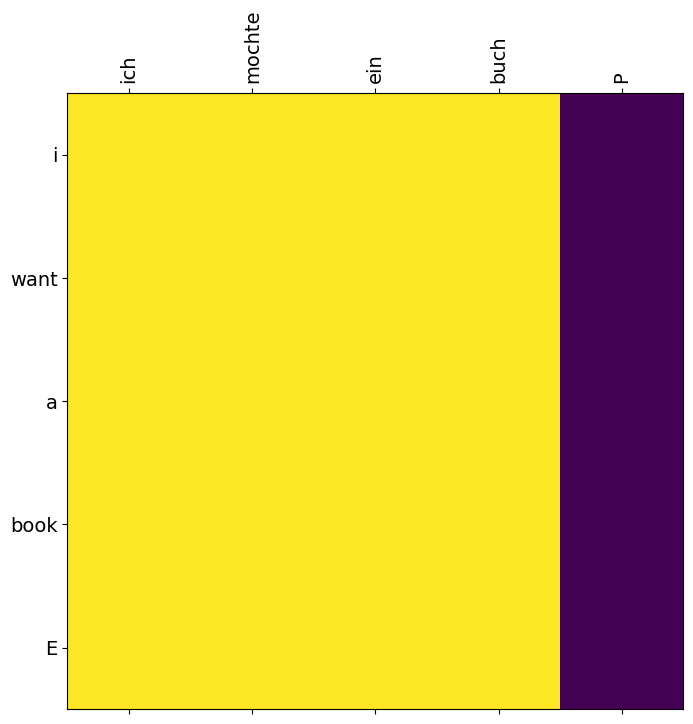

In [23]:
print('first head of last state enc_self_attns')
showgraph(enc_self_attns) # P is masked as it is padding and to be avoided.

print('first head of last state dec_self_attns')
showgraph(dec_self_attns) # Upper triangular masking.

print('first head of last state dec_enc_attns')
showgraph(dec_enc_attns)  # Again, P is padded.